In [2]:
!pip3 install lightgbm

# ML part

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_precision_score, matthews_corrcoef, f1_score
from sklearn import preprocessing
import numpy as np 
import pandas as pd
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve
import lightgbm
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
columns = ['angle', 'eta', 'pt', 'eta_sum', "pl", "id"]
DATA = pd.read_csv("data/Dataset.csv")[columns]

In [6]:
DATA

,angle,eta,pt,eta_sum,pl,id
0,0.028562,8.204541,2.108073,4.196049,69.996793,HNL
1,0.047040,8.633979,0.543982,5.039676,41.999044,HNL
2,0.066814,8.189327,0.103869,6.338688,29.397594,HNL
3,0.115996,7.331676,0.363074,4.850221,23.193333,HNL
4,0.032009,8.695774,1.332833,4.533561,62.029203,HNL
...,...,...,...,...,...,...
7298,0.082426,8.229011,1.098946,4.250610,38.536700,nu
7299,0.047537,7.525419,1.642597,3.629671,30.941500,nu
7300,0.041720,8.608324,1.969009,4.451474,84.412940,nu
7301,0.131722,6.786665,1.502157,3.792704,33.313090,nu


In [53]:
X0, y0 = DATA[columns[:-1]], DATA['id']

In [54]:
X0

,angle,eta,pt,eta_sum,pl
0,0.028562,8.204541,2.108073,4.196049,69.996793
1,0.047040,8.633979,0.543982,5.039676,41.999044
2,0.066814,8.189327,0.103869,6.338688,29.397594
3,0.115996,7.331676,0.363074,4.850221,23.193333
4,0.032009,8.695774,1.332833,4.533561,62.029203
...,...,...,...,...,...
7298,0.082426,8.229011,1.098946,4.250610,38.536700
7299,0.047537,7.525419,1.642597,3.629671,30.941500
7300,0.041720,8.608324,1.969009,4.451474,84.412940
7301,0.131722,6.786665,1.502157,3.792704,33.313090


## Preprocessing

In [44]:
y0

0       HNL
1       HNL
2       HNL
3       HNL
4       HNL
       ... 
7298     nu
7299     nu
7300     nu
7301     nu
7302     nu
Name: id, Length: 7303, dtype: object

In [61]:
y = preprocessing.LabelEncoder().fit(['nu', 'HNL']).transform(y0)
y

array([0, 0, 0, ..., 1, 1, 1])

In [68]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X0)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42)
rng = np.random.RandomState(42)

/home/eduard/miniconda3/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [47]:
def bootstrap_metric(x, 
                     y,
                     metric_fn,
                     samples_cnt = 100,
                     alpha = 0.05,
                     random_state = 42):
    size = len(x)
    
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)
        
        x_boot = x[poses]
        y_boot = y[poses]
        
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val
        if it%10 == 0:
            print(it, "...")
    
    return b_metric

## Choose model

In [65]:
model = RandomForestClassifier()
#model = lightgbm.LGBMClassifier()

## Estimate model

In [64]:
# Accuracy. GBDT
model = lightgbm.LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sum(y_pred == y_test)/len(y_test)

0.864184008762322

In [69]:
# cross_val. GBDT
model = lightgbm.LGBMClassifier()
cross_val_score(model, X_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')

array([0.88925895, 0.90044697, 0.8992629 ])

In [66]:
# Accuracy. RF
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sum(y_pred == y_test)/len(y_test)

0.8625410733844469

In [70]:
# cross_val. RF
model = RandomForestClassifier()
cross_val_score(model, X_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')

array([0.89537713, 0.89307661, 0.89770867])

In [63]:
# f1 score. Bootstrap
alpha = 0.05
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
cor = matthews_corrcoef(y_test, y_pred)
boot_mat_score = bootstrap_metric(y_test, y_pred, metric_fn=lambda x, y: f1_score(y_true=x, y_pred=y) , alpha = alpha)
print("Model: {0}".format(model), " \t f1-score: ", np.quantile(boot_mat_score, q=[alpha/2, 1 - alpha/2]))

0 ...
10 ...
20 ...
30 ...
40 ...
50 ...
60 ...
70 ...
80 ...
90 ...
Model: LGBMClassifier()  	 f1-score:  [0.88021731 0.90393441]


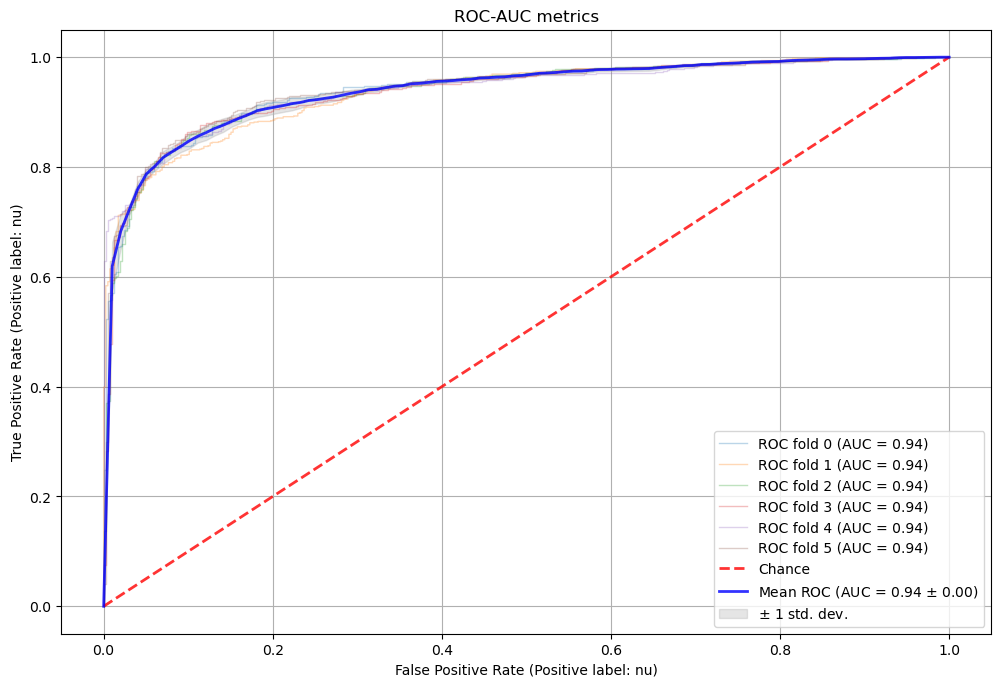

In [50]:

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X, y = X_scaled, y0.to_numpy()

fig, ax = plt.subplots(figsize = (12,8), dpi = 100)
plt.grid()
for i, (train, test) in enumerate(cv.split(X,y)):
    model.fit(X[train], y[train])
    viz = RocCurveDisplay.from_estimator(
        model,
        X[test],
        y[test],
        name="ROC fold {}".format(i),
        alpha=0.3,
        lw=1,
        ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="ROC-AUC metrics",
)
ax.legend(loc="lower right")
plt.show()

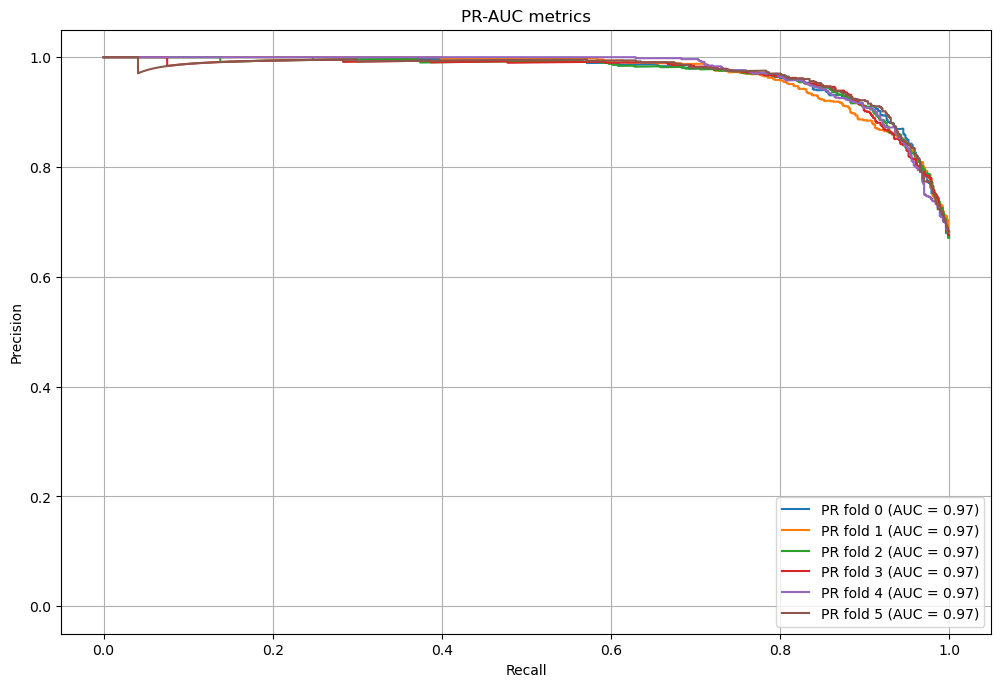

In [51]:
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)


fig, ax = plt.subplots(figsize = (12,8), dpi = 100)
plt.grid()
for i, (train, test) in enumerate(cv.split(X,y)):
    model.fit(X[train], y[train])
    pred_proba = model.predict_proba(X[test])
    precision, recall, _ = precision_recall_curve(y[test], pred_proba[:, 1], pos_label = 'nu')
    auc_0 = auc(recall, precision)
    aucs.append(auc_0)
    ax.plot(recall, precision, label="PR fold {}".format(i) + " (AUC = %0.2f)" % auc_0)  
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
ax.set(
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="PR-AUC metrics",
)
ax.legend(loc="lower right")
plt.show()

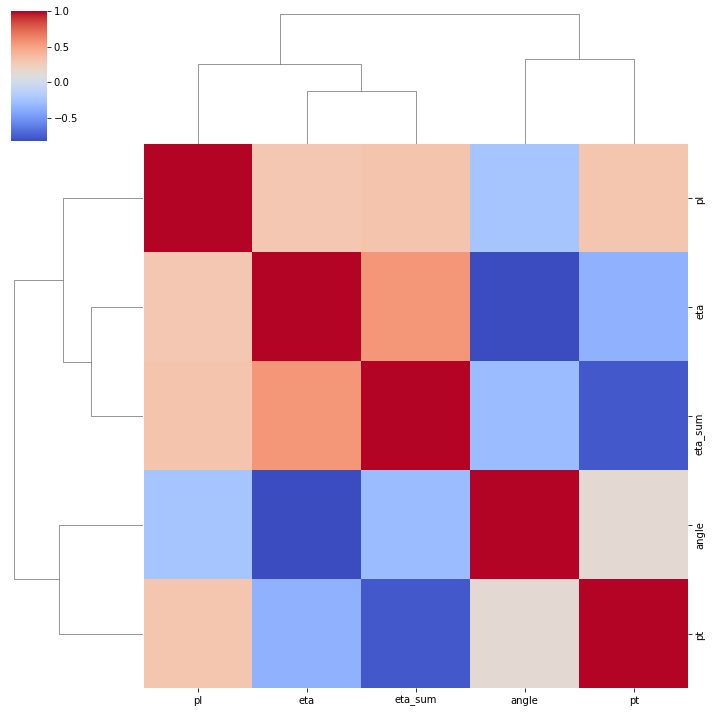

In [58]:
corr_matrix = X0.corr(method='spearman')
res = sns.clustermap(corr_matrix, method='weighted', figsize=(10, 10), cmap='coolwarm')